/storage/home/xmj5002/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/storage/home/xmj5002/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/storage/icds/RISE/sw8/anaconda/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


  SOC Code                                Title       aii       aug  aii_p  \
0  11-1011                     Chief Executives  0.000000  0.000000      0   
1  11-1021      General and Operations Managers  0.058824  0.070175      9   
2  11-2011  Advertising and Promotions Managers  0.000000  0.000000      0   
3  11-2021                   Marketing Managers  0.000000  0.000000      0   
4  11-2022                       Sales Managers  0.058824  0.000000      9   

   aug_p  
0      0  
1      7  
2      0  
3      0  
4      0  
Index(['SOC Code', 'Title', 'aii', 'aug', 'aii_p', 'aug_p'], dtype='object')
Cluster centers in original units:
       aii_p      aug_p  cluster_id
0   5.562212   3.260369           0
1  17.954545  32.965909           1
2  50.240000  73.040000           2
3  38.765766   7.639640           3

Cluster mean positions:
   cluster_id      aii_p      aug_p
0           0   5.562212   3.260369
1           1  17.954545  32.965909
2           2  50.240000  73.040000
3   

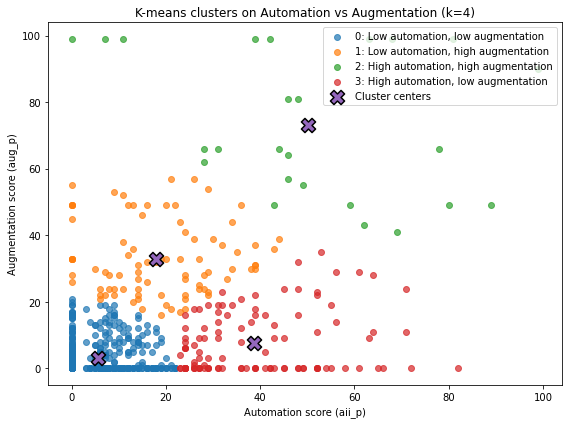

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt



df = pd.read_csv("datasets/2022/auto_augment.csv")

print(df.head())
print(df.columns)


# keep only rows with non-missing automation / augmentation scores

df = df.dropna(subset=["aii_p", "aug_p"]).copy()

# later
# df = df[df["SOC Code"] != "99-9999"]

# select features for clustering

# feature_cols = ["aii", "aug"]
feature_cols = ["aii_p", "aug_p"]
X = df[feature_cols].values # shape: (n_occupations, 2)

# standardize for K means

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# run k means (k = 4)

k = 4
kmeans = KMeans(
    n_clusters=k,
    random_state=41,
    n_init=50,
    max_iter= 1000 # tried 20)
)
kmeans.fit(X_scaled)

# add cluster IDs to df
df["cluster_id"] = kmeans.labels_ # 0, 1, 2, 3

# inspect cluster centers

# cluster centers are in standardized space, need to transform back to original aii / augmentation scale

centers_scaled = kmeans.cluster_centers_
centers_original = scaler.inverse_transform(centers_scaled)

centers_df = pd.DataFrame(
    centers_original,
    columns=feature_cols
)

centers_df["cluster_id"] = range(k)

print("Cluster centers in original units:")
print(centers_df)

# make readable cluster names
# use median of aii and aug to determine whats high/low then classify each cluster based on its mean position

aii_median = df["aii_p"].median()
aug_median = df["aug_p"].median()

cluster_stats = (
    df.groupby("cluster_id")[["aii_p", "aug_p"]]
      .mean()
      .reset_index()
)

print("\nCluster mean positions:")
print(cluster_stats)




cluster_name_map = {}


# centers_df has columns: ["aii_p", "aug_p", "cluster_id"]

# with percentile choose thresholds in percentil e space

auto_thresh = 30
aug_thresh = 30

for _, row in cluster_stats.iterrows():
    cid = row["cluster_id"]
    center_aii = row["aii_p"]
    center_aug = row["aug_p"]


    if center_aii >= auto_thresh and center_aug >= aug_thresh:
        name = "High automation, high augmentation"
    elif center_aii >= auto_thresh and center_aug < aug_thresh:
        name = "High automation, low augmentation"
    elif center_aii < auto_thresh and center_aug >= aug_thresh:
        name = "Low automation, high augmentation"
    else:
        name = "Low automation, low augmentation"


    cluster_name_map[cid] = name


print("\nCluster ID -> Name mapping: ")
for cid, name in cluster_name_map.items():
    print(f" {cid}: {name}")

# attatch names

df["cluster_name"] = df["cluster_id"].map(cluster_name_map)

# visualize automation vs augmentation by cluster

plt.figure(figsize=(8, 6))

for cid, group in df.groupby("cluster_id"):
    plt.scatter(
        group["aii_p"],
        group["aug_p"],
        label=f"{cid}: {cluster_name_map[cid]}",
        alpha=0.7
    )

# plot cluster centers
plt.scatter(
    centers_original[:, 0],
    centers_original[:, 1],
    marker="X",
    s=200,
    edgecolor="black",
    linewidth=1.5,
    label="Cluster centers"
)

plt.xlabel("Automation score (aii_p)")
plt.ylabel("Augmentation score (aug_p)")
plt.title("K-means clusters on Automation vs Augmentation (k=4)")
plt.legend()
plt.tight_layout()
plt.show()

